# Online Shopping Behaviour / Intention Prediction
#### Tjark Petersen, May 2020

In this notebook I apply preprocessing and feature engineering,train several models (standard ML + ANN), select a suitable model and store it for deployment. I use scikit's piepline module to makes sure the same processing is applied to different sets of the data. I store the final pripeline in the "deployment" folder. In the same folder, I set up a simple flask-based API to deploy the final pipeline. The files allow to run the app a) in a docker container, b) in IBM Cloud Foundry and c) in AWS Beanstalk.

<img src="pipeline.png">

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from joblib import dump

Using TensorFlow backend.


### Load data

In [277]:
df = pd.read_csv('../files/online_shoppers_intention.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [278]:
# delete the duration -1 cases
print(df[df.Administrative_Duration == -1].index)
print(df[df.Informational_Duration == -1].index)
print(df[df.ProductRelated_Duration == -1].index)

Int64Index([   2,    6,    7,   16,   21,   24,   49,   50,   64,  132,  140,
             181,  182,  252,  383,  532,  540,  562,  591,  638, 2046, 2052,
            2061, 4799, 4915, 5095, 5096, 5107, 5124, 6260, 7210, 8052, 8636],
           dtype='int64')
Int64Index([   2,    6,    7,   16,   21,   24,   49,   50,   64,  132,  140,
             181,  182,  252,  383,  532,  540,  562,  591,  638, 2046, 2052,
            2061, 4799, 4915, 5095, 5096, 5107, 5124, 6260, 7210, 8052, 8636],
           dtype='int64')
Int64Index([   2,    6,    7,   16,   21,   24,   49,   50,   64,  132,  140,
             181,  182,  252,  383,  532,  540,  562,  591,  638, 2046, 2052,
            2061, 4799, 4915, 5095, 5096, 5107, 5124, 6260, 7210, 8052, 8636],
           dtype='int64')


In [279]:
# delete these 33 cases 
df = df[df.Administrative_Duration != -1]

In [280]:
# binarize the label
df['Revenue'] = df['Revenue'].apply(lambda x: 1 if (x is True) else 0)

# split the data into train and test set
X=df.iloc[:,:-1]
y=df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [282]:
sum(y_test)

561

### Data Preprocessing & Feature Engineering

In [217]:
# custum transformation for numerical data

class SkewnessTransformer(BaseEstimator, TransformerMixin):

    def __init__( self):
        self.name = 'numerical features'
        
    def feature_transform(self, df, func, add, columns=None):
        
        if columns is not None:
            df_temp = df[columns].astype('float64')
        else:
            df_temp = df.astype('float64')
        df_transformed = pd.DataFrame(df_temp.apply(lambda x: func(x+add)), columns = df_temp.columns)
        return df_transformed.values
        
    def fit(self, X, y = None):
        return self 

    def transform(self, X, y = None):
        X = self.feature_transform(df=X, func=np.log, add=0.001)
        return X
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    

class InteractionTransformer(BaseEstimator, TransformerMixin):

    def __init__( self):
        self.name = 'interactions of numerical features'
        
    def add_interaction(self, df, col_1, col_2):
        name = col_1 + col_2
        df[name] = df[col_1] * df[col_2]
        return df
    
    def add_time_feature(self, df, col_1):
        name = col_1 + '_time_share'
        df[name] = df[col_1]/(df['Informational_Duration'] + df['Administrative_Duration'] + df['ProductRelated_Duration'] + 1)
        return df
        
    def fit(self, X, y = None):
        return self 

    def transform(self, X, y = None):
        X = self.add_interaction(df=X, col_1='Administrative', col_2='PageValues')
        X = self.add_time_feature(df=X, col_1='Informational_Duration')
        X = self.add_time_feature(df=X, col_1='Administrative_Duration')
        X = self.add_time_feature(df=X, col_1='ProductRelated_Duration')
        return X.values
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

# currently not in use  
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    
    def __init__( self):
        self.name = 'categorical features'
    
    def fit(self, X, y = None):
        return self 

    def transform(self, X, y = None):
        # X = self.get_binary_weekend(df=X)
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [218]:

cat_cols = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']
num_cols = ['Administrative',
             'Administrative_Duration',
             'Informational',
             'Informational_Duration',
             'ProductRelated',
             'ProductRelated_Duration',
             'BounceRates',
             'ExitRates',
             'PageValues',
             'SpecialDay']
label_col = ['Revenue']

categorical_pipeline = Pipeline( steps = [('one_hot_encoder', OneHotEncoder(handle_unknown='ignore') )])


numerical_pipeline = Pipeline( steps = [('median_imputer', SimpleImputer(missing_values=np.nan, strategy='median') ),
                                        ('standardscaler', StandardScaler() )] )

numerical_pipeline_log = Pipeline( steps = [ ('log_transformer', SkewnessTransformer() ),
                                             ('median_imputer', SimpleImputer(missing_values=np.nan, strategy='median') ),
                                             ('standardscaler', StandardScaler() )] )

numerical_pipeline_inter = Pipeline( steps = [ ('interaction_transformer', InteractionTransformer() ),
                                             ('median_imputer', SimpleImputer(missing_values=np.nan, strategy='median') ),
                                             ('standardscaler', StandardScaler() )] )
                                                        
plain_pipeline = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, num_cols),
        ('cat', categorical_pipeline, cat_cols)])

log_pipeline = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline_log, num_cols),
        ('cat', categorical_pipeline, cat_cols)])

inter_pipeline = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline_inter, num_cols),
        ('cat', categorical_pipeline, cat_cols)])

# Modelling & Evaluation

In [328]:
# create NN model
def create_NN():
    model = Sequential()
    model.add(Dense(70, input_dim=75, activation='relu'))
    model.add(Dropout(rate=0.4))
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# models
models = {
    'LogisticRegression': LogisticRegression(solver='lbfgs', max_iter = 500),
    'GradientBoosting': GradientBoostingClassifier(), 
    'RandomForest': RandomForestClassifier(),
    'NN': KerasClassifier(build_fn=create_NN, epochs=10, batch_size=30, verbose=0)
}

In [330]:
def get_full_pipeline(processing, estimator):
    full_pipeline = Pipeline( steps = [ ( 'preprocessor', processing), ( 'model', estimator ) ] )
    return full_pipeline

feature_eng_options = {
    'plain': plain_pipeline,
    'log_transformed': log_pipeline,
    #'with_interaction': inter_pipeline
}

In [332]:
fitted_models = []
for preprocessor_name, preprocessor in feature_eng_options.items():
    for model_name, model in models.items():
        full_pipeline = get_full_pipeline(processing=preprocessor, estimator=model)
        full_pipeline.fit(X_train, y_train)
        y_pred = full_pipeline.predict(X_test)
        print('---------------')
        print('Train Accuracy', model_name, preprocessor_name, full_pipeline.score(X_train, y_train))
        print('Test Accuracy', model_name, preprocessor_name, full_pipeline.score(X_test, y_test))
        print('Test F1', model_name, preprocessor_name, f1_score(y_true=y_test, y_pred=y_pred))
        print('Test Precision', model_name, preprocessor_name, precision_score(y_true=y_test, y_pred=y_pred))
        print('Test Recall', model_name, preprocessor_name, recall_score(y_true=y_test, y_pred=y_pred))
        print('Test AUC', model_name, preprocessor_name, roc_auc_score(y_true=y_test, y_score=y_pred))
        fitted_models.append({'model_name': model_name, 'preprocessor_name': preprocessor_name, 'fitted_pipeline': full_pipeline})

---------------
Train Accuracy LogisticRegression plain 0.883466945509469
Test Accuracy LogisticRegression plain 0.891869918699187
Test F1 LogisticRegression plain 0.5501691093573844
Test Precision LogisticRegression plain 0.7484662576687117
Test Recall LogisticRegression plain 0.43493761140819964
Test AUC LogisticRegression plain 0.7043655778357715
---------------
Train Accuracy GradientBoosting plain 0.9183222958057395
Test Accuracy GradientBoosting plain 0.910840108401084
Test F1 GradientBoosting plain 0.686964795432921
Test Precision GradientBoosting plain 0.736734693877551
Test Recall GradientBoosting plain 0.64349376114082
Test AUC GradientBoosting plain 0.8011332659970639
---------------
Train Accuracy RandomForest plain 0.9901243174160567
Test Accuracy RandomForest plain 0.8997289972899729
Test F1 RandomForest plain 0.5960698689956332
Test Precision RandomForest plain 0.7690140845070422
Test Recall RandomForest plain 0.48663101604278075
Test AUC RandomForest plain 0.73021228015

# Final Model Selection & Evaluation

In [256]:
# select best model and preprocessing
model_index = 1
print(fitted_models[model_index])
final_pipeline = fitted_models[model_index].get('fitted_pipeline')
# take care // why is the re-fit necessary? 
final_pipeline = final_pipeline.fit(X_train, y_train)

{'model_name': 'GradientBoosting', 'preprocessor_name': 'plain', 'fitted_pipeline': Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('median_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                      

In [261]:
# train vs test set accuarcy
final_pipeline.score(X=X_train, y=y_train), final_pipeline.score(X=X_test, y=y_test)

(0.9183222958057395, 0.910840108401084)

In [262]:
hyper_params = {
    "model__loss":["deviance"],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__min_samples_split": np.linspace(0.1, 0.5, 3),
    "model__min_samples_leaf": np.linspace(0.1, 0.5, 3),
    "model__max_depth":[3,5,8],
    "model__max_features":["log2","sqrt"],
    "model__criterion": ["friedman_mse",  "mae"],
    "model__subsample":[0.5, 0.8, 0.9, 1.0],
    "model__n_estimators":[10]
    }

optimised_final_pipeline = GridSearchCV(final_pipeline, hyper_params, cv=10, n_jobs=-1)

In [263]:
# fit the GB with the selected hyper parameters, evaluate accuracy again
optimised_final_pipeline.fit(X=X_train, y=y_train)
optimised_final_pipeline.score(X=X_train, y=y_train), final_pipeline.score(X=X_test, y=y_test)

(0.8763796909492274, 0.910840108401084)

In [283]:
optimised_final_pipeline.score(X=X_train, y=y_train), final_pipeline.score(X=X_test, y=y_test)

(0.8763796909492274, 0.910840108401084)

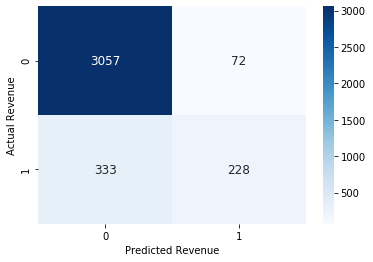

In [284]:
pred = optimised_final_pipeline.predict(X=X_test)
cm = confusion_matrix(y_true=y_test, y_pred=pred)
df_cm = pd.DataFrame(cm)
df_cm.index.name = 'Actual Revenue'
df_cm.columns.name = 'Predicted Revenue'
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='g', annot_kws={"size": 12});

### Save model to disk

In [285]:
dump(optimised_final_pipeline, 'revenue_prediction_final_pipeline.joblib') 

['revenue_prediction_final_pipeline.joblib']

In [286]:
# store test data for expemlar http request
X_test.iloc[25,:].to_json('test_instance_0.json')
y_test.iloc[25]

1

In [287]:
cols = X_test.columns.tolist()
dump(cols, 'input_columns.joblib') 

['input_columns.joblib']

## @ Thanh Ha: 
- es fehlt noch etwas narrative ich weiß..
- mich beunruhigt, dass meine feature eng optionen keine wirkliche auswirkung haben
- das gridsearch cv läuft ewigkeiten 
- das neural network performt nicht besser als die standard modelle -> ich glaube es liegt an der geringen datenmenge (NNs performen mit großen datenmengen besser), was denkst du? 
- Ich hab auch das Problem, dass man bei Keras die input_dim spezifizieren muss, aber durch die feature eng varianten (with_interaction) variiert diese...weißt du wie man das löst? X.shape[1] funktiniert hier nicht :/ 
- was würdest du ändern?